<div style="text-align: center"> 

## Data Analysis & Modeling
## Machine Learning
### Inma Jiménez

## Índice

1. [Preparación de los datos](#1.-Preparación-de-los-datos)


2. [Análisis de las variables](#2.-Análisis-de-las-variables)


3. [Machine Learning](#3.-Machine-Learning)

    3.1.[División en Train-Test](#3.1.-División-en-Train-Test)
       
    3.2. [Modelo de Regresión](#3.2.-Modelo-de-Regresión)
    
      3.2.1. [División en Train-Test sobre conjunto Train](#3.2.1.-División-en-Train-Test-sobre-conjunto-Train)
    
      3.2.2. [Modelo CatBoost](#3.2.2.-Modelo-CatBoost)
      
      3.2.3. [Modelo de Regresión Lineal](#3.2.3.-Modelo-de-Regresión-Lineal)
      
      3.2.4. [Modelo GradientBoostingRegressor](#3.2.4.-Modelo-GradientBoostingRegressor)
      
    3.4. [Se guarda el modelo](#3.4.-Se-guarda-el-modelo)
    
    
    
4. [Conclusión](#3.-Conclusión)

#### Librerías

In [2]:
from catboost import CatBoostRegressor, Pool

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import pickle

import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split

#### Funciones

In [3]:
'''
Función que permite sustituir valores nulos de una columna específica.

Acoge los siguientes argumentos:

    - 'df', refiere al DataFrame sobre el que se quiere trabajar.
    
    - 'column_name' es la columna sobre la que se va a sustituir el valor nulo.
    
    - 'row_name' es la fila sobre la que se quiere sustituir el valor nulo.
    
    - 'value_1' indica el valor de la celda que ha de buscar la función para identificar la fila sobre la que 
    se quiere sustituir el valor nulo.
    
    - 'value_2' es el valor por el que se quiere sustituir el valor nulo.
    
'''

def sustitution(df, column_name, row_name, value_1, value_2):
    
    for index, row in (df.loc[df[column_name].isnull()]).iterrows():
    
        if row[row_name] == value_1:
            data_nba[column_name][index] = value_2
            
    
    return df

In [4]:
'''
Esta función permite extraer un resumen de información sobre el conuntos de datos del DataSet sobre el que se está
trabajando.

El argumento que se requiere es el siguiente:


        - 'df' que refiere al DataFrame sobre el que se quiere trabajar.

'''

def data_report(df):

    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T

In [5]:
'''
Esta función permite visualizar un histograma con las 'features importance' de cada una de las variables incluidas
en la 'X' que se ha definido anteriormente.

Los argumentos a incluir son los siguientes:

    - 'features' se refiere al nombre de las columnas del DataFrame.
    Se incluye la variable que contiene el conjunto train + '.columns' para obtener el nombre de 
    cada una de las features. Ej. 'X.columns'
    
    - 'model_importances' es la variable sobre la que se ejecuta el modelo elegido y  sobre la que se ejecutará
    la función 'feature_importances_'.
    Se incluye la variable que contiene el modelo a ejecutar + '.feature_importances_'. 
    Ej. 'importance_feature.feature_importances_'
    
'''


def plot_feature_importance(features, model_importances):

    indices = np.argsort(model_importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), model_importances[indices], color='y', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

### 1. Preparación de los datos

Se importa el csv creado - *data_nba.csv* - con los datos de la API de la NBA extaidos, preparados y limpiados anteriormente

In [6]:
pd.options.display.max_columns = None

data_nba = pd.read_csv('/home/inma/Escritorio/The Bridge/Data_Science_Curso/Clase/Repository_Inma/ML/1. Data/data_nba_ML.csv')
data_nba

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
0,2011-2012,2011.0,201142,Kevin Durant,2007,A,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0
1,2011-2012,2011.0,977,Kobe Bryant,1996,B,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0
2,2011-2012,2011.0,2544,LeBron James,2003,A,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0
3,2011-2012,2011.0,201567,Kevin Love,2008,AP,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0
4,2011-2012,2011.0,201566,Russell Westbrook,2008,B,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,2022-2023,2022.0,1627853,Ryan Arcidiacono,2016,B,1.90,88.5,473,Portland,Trail Blazers,Western,13,0.2,0.0,0.300,0.462,0.077,16.7,0.000,0.077,0.0,0.308,0.077,25.0,0.2,2.8,0.3,0.0,0.3,0.2,0.2,0.2,2,0,0.300,6,1,16.7,0,0,0.0,4,1,25.0,36,3,4,0,4,2,2,3,0.0
5834,2022-2023,2022.0,1631205,Buddy Boeheim,2022,A,1.98,93.0,474,Detroit,Pistons,Eastern,1,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0.0,1,0,0,0,0,0,0,0,0.0
5835,2022-2023,2022.0,1630577,Julian Champagnie,2022,A,2.01,98.4,475,San Antonio,Spurs,Western,2,0.0,0.0,-0.500,1.000,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.5,0.0,0,0,-0.500,2,0,0.0,0,0,0.0,1,0,0.0,7,0,0,0,0,0,1,0,0.0
5836,2022-2023,2022.0,1631211,Trevor Keels,2022,B,1.93,100.2,476,New York,Knicks,Eastern,1,0.0,0.0,0.000,1.000,0.000,0.0,0.000,0.000,0.0,1.000,0.000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0.000,1,0,0.0,0,0,0.0,1,0,0.0,1,0,1,0,1,0,0,0,0.0


In [7]:
# El DataSet cuenta con 5839 filas y 54 columnas

data_nba.shape

(5838, 54)

In [8]:
# Se vuelve a comprobar si hay valores nulos

data_nba.isnull().sum()

temporada                  0
anio                       0
id_jugador                 0
nombre_jugador             0
draft_anio                 0
posicion                 133
altura                   118
peso_kg                  118
num_ranking                0
ciudad_equipo              0
nombre_equipo              0
conferencia                0
partidos_jugados           0
asistencias_pp             0
tapones_pp                 0
eficiencia_tiro_pp         0
tci_pp                     0
tce_pp                     0
porcentaje_tc_pp           0
tli_pp                     0
tle_pp                     0
porcentaje_tl_pp           0
tti_pp                     0
tte_pp                     0
porcentaje_tt_pp           0
puntos_pp                  0
minutos_pp                 0
reb_def_pp                 0
reb_of_pp                  0
total_rebotes_pp           0
faltas_pp                  0
robos_pp                   0
perdidas_pp                0
asistencias_total          0
tapones_total 

In [9]:
# Hay 133 valores nulos identificados en la columna 'posicion'

missing_posicion = data_nba.loc[data_nba['posicion'].isnull()]
missing_posicion

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
214,2011-2012,2011.0,2246,Mehmet Okur,2002,NaN,NaN,NaN,215,New Jersey,Nets,Eastern,17,1.8,0.2,8.294,8.176,3.059,37.4,0.294,1.353,60.0,4.235,1.353,31.9,7.6,26.7,3.5,1.3,4.8,2.6,0.5,1.4,30,5,8.294,139,52,37.4,5,3,60.0,72,23,31.9,454,130,59,22,81,25,9,45,0.0
260,2011-2012,2011.0,201611,Henry Walker,2008,NaN,NaN,NaN,261,New York,Knicks,Eastern,32,1.2,0.2,5.969,5.344,2.125,39.8,0.625,1.125,85.0,3.531,1.125,31.9,5.9,19.4,2.2,0.3,2.5,2.6,0.5,1.0,37,7,5.969,171,68,39.8,20,17,85.0,113,36,31.9,620,189,71,9,80,35,19,84,0.0
271,2011-2012,2011.0,2427,Roger Mason Jr.,2002,NaN,NaN,NaN,272,Washington,Wizards,Eastern,52,0.9,0.1,4.365,4.962,1.981,39.9,0.519,1.135,77.8,2.962,1.135,38.3,5.5,13.4,1.2,0.1,1.3,0.6,0.2,0.6,47,5,4.365,258,103,39.9,27,21,77.8,154,59,38.3,697,286,62,7,69,32,13,33,0.0
279,2011-2012,2011.0,2404,Chris Wilcox,2002,NaN,NaN,NaN,280,Boston,Celtics,Eastern,28,0.4,0.3,7.786,3.821,2.286,59.8,1.393,0.000,61.5,0.000,0.000,0.0,5.4,17.2,3.0,1.4,4.4,2.3,0.3,1.0,12,9,7.786,107,64,59.8,39,24,61.5,0,0,0.0,481,152,84,38,122,30,11,64,2.0
296,2011-2012,2011.0,979,Jermaine O'Neal,1996,NaN,NaN,NaN,297,Boston,Celtics,Eastern,25,0.4,1.7,8.880,4.800,2.080,43.3,1.240,0.000,67.7,0.000,0.000,0.0,5.0,22.8,3.9,1.5,5.4,3.2,0.3,0.8,10,43,8.880,120,52,43.3,31,21,67.7,0,0,0.0,570,125,98,37,135,21,8,80,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,2015-2016,2015.0,1626262,Coty Clarke,0,NaN,2.01,102.1,379,Boston,Celtics,Eastern,3,0.0,0.0,1.300,1.333,0.667,50.0,0.000,0.667,0.0,0.667,0.667,100.0,2.0,2.0,0.3,0.0,0.3,0.0,0.0,0.3,0,0,1.300,4,2,50.0,0,0,0.0,2,2,100.0,6,6,1,0,1,1,0,0,0.0
2336,2015-2016,2015.0,1626146,Cliff Alexander,2015,NaN,2.03,108.9,393,Portland,Trail Blazers,Western,8,0.0,0.3,1.600,1.250,0.625,50.0,0.000,0.000,0.0,0.000,0.000,0.0,1.3,4.5,0.5,0.3,0.8,0.1,0.1,0.1,0,2,1.600,10,5,50.0,0,0,0.0,0,0,0.0,36,10,4,2,6,1,1,1,0.0
2339,2015-2016,2015.0,1626242,Luis Montero,2015,NaN,2.01,83.9,396,Portland,Trail Blazers,Western,12,0.1,0.0,0.000,1.583,0.417,26.3,0.333,0.083,75.0,0.750,0.083,11.1,1.2,3.5,0.3,0.0,0.3,0.1,0.0,0.3,1,0,0.000,19,5,26.3,4,3,75.0,9,1,11.1,42,14,4,0,4,4,0,1,0.0
2354,2015-2016,2015.0,1626254,Maurice Ndour,2015,NaN,2.06,90.7,411,Dallas,Mavericks,Western,0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0


In [10]:
# Hay 118 valores nulos identificados en la columna 'altura'

missing_altura = data_nba.loc[data_nba['altura'].isnull()]
missing_altura 

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
214,2011-2012,2011.0,2246,Mehmet Okur,2002,NaN,NaN,NaN,215,New Jersey,Nets,Eastern,17,1.8,0.2,8.294,8.176,3.059,37.4,0.294,1.353,60.0,4.235,1.353,31.9,7.6,26.7,3.5,1.3,4.8,2.6,0.5,1.4,30,5,8.294,139,52,37.4,5,3,60.0,72,23,31.9,454,130,59,22,81,25,9,45,0.0
260,2011-2012,2011.0,201611,Henry Walker,2008,NaN,NaN,NaN,261,New York,Knicks,Eastern,32,1.2,0.2,5.969,5.344,2.125,39.8,0.625,1.125,85.0,3.531,1.125,31.9,5.9,19.4,2.2,0.3,2.5,2.6,0.5,1.0,37,7,5.969,171,68,39.8,20,17,85.0,113,36,31.9,620,189,71,9,80,35,19,84,0.0
271,2011-2012,2011.0,2427,Roger Mason Jr.,2002,NaN,NaN,NaN,272,Washington,Wizards,Eastern,52,0.9,0.1,4.365,4.962,1.981,39.9,0.519,1.135,77.8,2.962,1.135,38.3,5.5,13.4,1.2,0.1,1.3,0.6,0.2,0.6,47,5,4.365,258,103,39.9,27,21,77.8,154,59,38.3,697,286,62,7,69,32,13,33,0.0
279,2011-2012,2011.0,2404,Chris Wilcox,2002,NaN,NaN,NaN,280,Boston,Celtics,Eastern,28,0.4,0.3,7.786,3.821,2.286,59.8,1.393,0.000,61.5,0.000,0.000,0.0,5.4,17.2,3.0,1.4,4.4,2.3,0.3,1.0,12,9,7.786,107,64,59.8,39,24,61.5,0,0,0.0,481,152,84,38,122,30,11,64,2.0
296,2011-2012,2011.0,979,Jermaine O'Neal,1996,NaN,NaN,NaN,297,Boston,Celtics,Eastern,25,0.4,1.7,8.880,4.800,2.080,43.3,1.240,0.000,67.7,0.000,0.000,0.0,5.0,22.8,3.9,1.5,5.4,3.2,0.3,0.8,10,43,8.880,120,52,43.3,31,21,67.7,0,0,0.0,570,125,98,37,135,21,8,80,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2013-2014,2013.0,2767,Royal Ivey,2004,NaN,NaN,NaN,481,Oklahoma City,Thunder,Western,2,0.0,0.0,-0.500,1.000,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,2.4,0.5,0.0,0.5,0.5,0.0,0.0,0,0,-0.500,2,0,0.0,0,0,0.0,1,0,0.0,5,0,1,0,1,0,0,1,0.0
1440,2013-2014,2013.0,203130,Darius Johnson-Odom,2012,NaN,NaN,NaN,482,Philadelphia,76ers,Eastern,3,0.3,0.0,-2.300,2.333,0.000,0.0,0.667,0.000,0.0,1.000,0.000,0.0,0.0,5.1,0.7,0.0,0.7,1.0,0.3,0.6,1,0,-2.300,7,0,0.0,2,0,0.0,3,0,0.0,15,0,2,0,2,2,1,3,0.0
1444,2013-2014,2013.0,202354,Dexter Pittman,2010,NaN,NaN,NaN,486,Atlanta,Hawks,Eastern,2,0.0,0.0,0.000,0.500,0.000,0.0,1.000,0.000,0.0,0.000,0.000,0.0,0.0,1.5,0.0,1.5,1.5,0.0,0.0,0.0,0,0,0.000,1,0,0.0,2,0,0.0,0,0,0.0,3,0,0,3,3,0,0,0,0.0
1446,2013-2014,2013.0,203147,Chris Smith,2012,NaN,NaN,NaN,488,New York,Knicks,Eastern,2,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0.0,2,0,0,0,0,0,0,0,0.0


In [11]:
# Hay 118 valores nulos identificados en la columna 'peso'

missing_peso = data_nba.loc[data_nba['peso_kg'].isnull()]
missing_peso

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
214,2011-2012,2011.0,2246,Mehmet Okur,2002,NaN,NaN,NaN,215,New Jersey,Nets,Eastern,17,1.8,0.2,8.294,8.176,3.059,37.4,0.294,1.353,60.0,4.235,1.353,31.9,7.6,26.7,3.5,1.3,4.8,2.6,0.5,1.4,30,5,8.294,139,52,37.4,5,3,60.0,72,23,31.9,454,130,59,22,81,25,9,45,0.0
260,2011-2012,2011.0,201611,Henry Walker,2008,NaN,NaN,NaN,261,New York,Knicks,Eastern,32,1.2,0.2,5.969,5.344,2.125,39.8,0.625,1.125,85.0,3.531,1.125,31.9,5.9,19.4,2.2,0.3,2.5,2.6,0.5,1.0,37,7,5.969,171,68,39.8,20,17,85.0,113,36,31.9,620,189,71,9,80,35,19,84,0.0
271,2011-2012,2011.0,2427,Roger Mason Jr.,2002,NaN,NaN,NaN,272,Washington,Wizards,Eastern,52,0.9,0.1,4.365,4.962,1.981,39.9,0.519,1.135,77.8,2.962,1.135,38.3,5.5,13.4,1.2,0.1,1.3,0.6,0.2,0.6,47,5,4.365,258,103,39.9,27,21,77.8,154,59,38.3,697,286,62,7,69,32,13,33,0.0
279,2011-2012,2011.0,2404,Chris Wilcox,2002,NaN,NaN,NaN,280,Boston,Celtics,Eastern,28,0.4,0.3,7.786,3.821,2.286,59.8,1.393,0.000,61.5,0.000,0.000,0.0,5.4,17.2,3.0,1.4,4.4,2.3,0.3,1.0,12,9,7.786,107,64,59.8,39,24,61.5,0,0,0.0,481,152,84,38,122,30,11,64,2.0
296,2011-2012,2011.0,979,Jermaine O'Neal,1996,NaN,NaN,NaN,297,Boston,Celtics,Eastern,25,0.4,1.7,8.880,4.800,2.080,43.3,1.240,0.000,67.7,0.000,0.000,0.0,5.0,22.8,3.9,1.5,5.4,3.2,0.3,0.8,10,43,8.880,120,52,43.3,31,21,67.7,0,0,0.0,570,125,98,37,135,21,8,80,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2013-2014,2013.0,2767,Royal Ivey,2004,NaN,NaN,NaN,481,Oklahoma City,Thunder,Western,2,0.0,0.0,-0.500,1.000,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,2.4,0.5,0.0,0.5,0.5,0.0,0.0,0,0,-0.500,2,0,0.0,0,0,0.0,1,0,0.0,5,0,1,0,1,0,0,1,0.0
1440,2013-2014,2013.0,203130,Darius Johnson-Odom,2012,NaN,NaN,NaN,482,Philadelphia,76ers,Eastern,3,0.3,0.0,-2.300,2.333,0.000,0.0,0.667,0.000,0.0,1.000,0.000,0.0,0.0,5.1,0.7,0.0,0.7,1.0,0.3,0.6,1,0,-2.300,7,0,0.0,2,0,0.0,3,0,0.0,15,0,2,0,2,2,1,3,0.0
1444,2013-2014,2013.0,202354,Dexter Pittman,2010,NaN,NaN,NaN,486,Atlanta,Hawks,Eastern,2,0.0,0.0,0.000,0.500,0.000,0.0,1.000,0.000,0.0,0.000,0.000,0.0,0.0,1.5,0.0,1.5,1.5,0.0,0.0,0.0,0,0,0.000,1,0,0.0,2,0,0.0,0,0,0.0,3,0,0,3,3,0,0,0,0.0
1446,2013-2014,2013.0,203147,Chris Smith,2012,NaN,NaN,NaN,488,New York,Knicks,Eastern,2,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0.0,2,0,0,0,0,0,0,0,0.0


In [12]:
'''
Parte de estos valores 'NaN' fueron corregidos en el ejercicio EDA buscando la información de la posición 
de juego de cada jugador en internet y se corrigió en el DataFrame directamente.

Se intentó hacer un bucle y sustituir la información en base al índice. Sin embargo, al obtener datos que se 
actualizan cada semana de la temporada 2022-2023 (que se está jugando en el momento actual), 
las filas y los índices se ven alterados. Por tanto, se decidió hacer específicamente por el nombre del 
jugador este cambio.

'''

sustitution(data_nba, 'posicion', 'nombre_jugador', 'T.J. McConnell', 'B')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Duje Dukan', 'AP')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Boban Marjanovic', 'P')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Marcelo Huertas', 'B')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Briante Weber', 'B')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Axel Toupane', 'E-A')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Salah Mejri', 'P')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Cristiano Felicio', 'P')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Christian Wood', 'AP')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Alex Stepheson', 'AP')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Coty Clarke', 'A')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Cliff Alexander', 'AP')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Luis Montero', 'E-A')
sustitution(data_nba, 'posicion', 'nombre_jugador', 'Maurice Ndour', 'P')
sustitution(data_nba, 'posicion', 'nombre_jugador', "JJ O'Brien", 'A')

/tmp/ipykernel_3852/2586037968.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nba[column_name][index] = value_2


,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
0,2011-2012,2011.0,201142,Kevin Durant,2007,A,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0
1,2011-2012,2011.0,977,Kobe Bryant,1996,B,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0
2,2011-2012,2011.0,2544,LeBron James,2003,A,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0
3,2011-2012,2011.0,201567,Kevin Love,2008,AP,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0
4,2011-2012,2011.0,201566,Russell Westbrook,2008,B,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,2022-2023,2022.0,1627853,Ryan Arcidiacono,2016,B,1.90,88.5,473,Portland,Trail Blazers,Western,13,0.2,0.0,0.300,0.462,0.077,16.7,0.000,0.077,0.0,0.308,0.077,25.0,0.2,2.8,0.3,0.0,0.3,0.2,0.2,0.2,2,0,0.300,6,1,16.7,0,0,0.0,4,1,25.0,36,3,4,0,4,2,2,3,0.0
5834,2022-2023,2022.0,1631205,Buddy Boeheim,2022,A,1.98,93.0,474,Detroit,Pistons,Eastern,1,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0.0,1,0,0,0,0,0,0,0,0.0
5835,2022-2023,2022.0,1630577,Julian Champagnie,2022,A,2.01,98.4,475,San Antonio,Spurs,Western,2,0.0,0.0,-0.500,1.000,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.5,0.0,0,0,-0.500,2,0,0.0,0,0,0.0,1,0,0.0,7,0,0,0,0,0,1,0,0.0
5836,2022-2023,2022.0,1631211,Trevor Keels,2022,B,1.93,100.2,476,New York,Knicks,Eastern,1,0.0,0.0,0.000,1.000,0.000,0.0,0.000,0.000,0.0,1.000,0.000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0.000,1,0,0.0,0,0,0.0,1,0,0.0,1,0,1,0,1,0,0,0,0.0


In [13]:
# Se eliminan el resto de valores NaN, ya que se tendrían que tratar los valores de manera individual y son solo 118

data_nba = data_nba.dropna()
data_nba

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
0,2011-2012,2011.0,201142,Kevin Durant,2007,A,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0
1,2011-2012,2011.0,977,Kobe Bryant,1996,B,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0
2,2011-2012,2011.0,2544,LeBron James,2003,A,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0
3,2011-2012,2011.0,201567,Kevin Love,2008,AP,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0
4,2011-2012,2011.0,201566,Russell Westbrook,2008,B,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,2022-2023,2022.0,1627853,Ryan Arcidiacono,2016,B,1.90,88.5,473,Portland,Trail Blazers,Western,13,0.2,0.0,0.300,0.462,0.077,16.7,0.000,0.077,0.0,0.308,0.077,25.0,0.2,2.8,0.3,0.0,0.3,0.2,0.2,0.2,2,0,0.300,6,1,16.7,0,0,0.0,4,1,25.0,36,3,4,0,4,2,2,3,0.0
5834,2022-2023,2022.0,1631205,Buddy Boeheim,2022,A,1.98,93.0,474,Detroit,Pistons,Eastern,1,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0.0,1,0,0,0,0,0,0,0,0.0
5835,2022-2023,2022.0,1630577,Julian Champagnie,2022,A,2.01,98.4,475,San Antonio,Spurs,Western,2,0.0,0.0,-0.500,1.000,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.5,0.0,0,0,-0.500,2,0,0.0,0,0,0.0,1,0,0.0,7,0,0,0,0,0,1,0,0.0
5836,2022-2023,2022.0,1631211,Trevor Keels,2022,B,1.93,100.2,476,New York,Knicks,Eastern,1,0.0,0.0,0.000,1.000,0.000,0.0,0.000,0.000,0.0,1.000,0.000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0.000,1,0,0.0,0,0,0.0,1,0,0.0,1,0,1,0,1,0,0,0,0.0


In [14]:
'''
Se crea un DataSet ('df_nba') sin la temporada 2022-2023. Ya que es la temporada que está sucendiendo actualmente y 
cada semana los datos se modifican con los nuevos estadísticos de los jugadores.

Este será el DataSet que se usará en el análisis posterior y para la definición de modelos de Machine Learning.

'''

df_nba = data_nba.loc[(data_nba['temporada'] != '2022-2023')]
df_nba

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
0,2011-2012,2011.0,201142,Kevin Durant,2007,A,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0
1,2011-2012,2011.0,977,Kobe Bryant,1996,B,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0
2,2011-2012,2011.0,2544,LeBron James,2003,A,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0
3,2011-2012,2011.0,201567,Kevin Love,2008,AP,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0
4,2011-2012,2011.0,201566,Russell Westbrook,2008,B,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356,2021-2022,2021.0,1630207,Nate Hinton,2020,E-A,1.96,95.3,489,Indiana,Pacers,Eastern,2,0.0,0.0,-1.000,0.500,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0,0,-1.000,1,0,0.0,0,0,0.0,0,0,0.0,2,0,0,0,0,1,0,0,0.0
5357,2021-2022,2021.0,1630624,Feron Hunt,2021,A,2.03,88.5,490,New York,Knicks,Eastern,2,0.5,0.0,0.000,1.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,4.0,0.0,0.5,0.5,0.5,0.5,0.5,1,0,0.000,2,0,0.0,0,0,0.0,0,0,0.0,8,0,0,1,1,1,1,1,0.0
5358,2021-2022,2021.0,1630525,David Johnson,2021,B,1.93,92.1,491,Toronto,Raptors,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,2,0,0,0,0,0,0,0,0.0
5359,2021-2022,2021.0,1629083,Arnoldas Kulboka,2018,A,2.08,94.8,492,Charlotte,Hornets,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,2.5,0.0,0.0,0.0,0.5,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,5,0,0,0,0,0,0,1,0.0


In [15]:
'''
Se calcula el PIR (Performance Index Rating) de cada uno de los jugadores de la NBA desde la temporada 2011-2012, 
hasta la temporada 2021-2022.

Se descarta la temporada 2022-2023, ya que es la temporada que está sucendiendo actualmente y cada semana
los datos se modifican con los nuevos estadísticos de los jugadores.

'''

pir = df_nba.loc[(df_nba.temporada >= '2011-2012') & (df_nba.temporada <= '2021-2022'), ['temporada',
                                                                                         'nombre_jugador',
                                                                                         'nombre_equipo',
                                                                                         'partidos_jugados',
                                                                                         'asistencias_total',
                                                                                         'tapones_total',
                                                                                         'tci_total',
                                                                                         'tce_total',
                                                                                         'tli_total',
                                                                                         'tle_total',                                                                
                                                                                         'tti_total',
                                                                                         'tte_total',
                                                                                         'puntos_total',
                                                                                         'rebotes_total',
                                                                                         'perdidas_total',
                                                                                         'robos_total',
                                                                                         'faltas_total',
                                                                                         'faltas_tecnicas_total']]

pir

,temporada,nombre_jugador,nombre_equipo,partidos_jugados,asistencias_total,tapones_total,tci_total,tce_total,tli_total,tle_total,tti_total,tte_total,puntos_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total
0,2011-2012,Kevin Durant,Thunder,66,231,77,1297,643,501,431,344,133,1850,527,248,88,133,6.0
1,2011-2012,Kobe Bryant,Lakers,58,264,18,1336,574,451,381,287,87,1616,313,204,69,105,10.0
2,2011-2012,LeBron James,Heat,62,387,50,1169,621,502,387,149,54,1683,492,213,115,96,3.0
3,2011-2012,Kevin Love,Timberwolves,55,111,28,1059,474,460,379,282,105,1432,734,128,47,152,4.0
4,2011-2012,Russell Westbrook,Thunder,66,362,21,1266,578,413,340,196,62,1558,301,239,112,147,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356,2021-2022,Nate Hinton,Pacers,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0
5357,2021-2022,Feron Hunt,Knicks,2,1,0,2,0,0,0,0,0,0,1,1,1,1,0.0
5358,2021-2022,David Johnson,Raptors,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0
5359,2021-2022,Arnoldas Kulboka,Hornets,2,0,0,1,0,0,0,1,0,0,0,0,0,1,0.0


In [16]:
'''
Para calcular el PIR medio de cada jugador por temporada, se itera sobre el DataFrame 'pir' y se
ejecuta la fórmula matemática que permite calcular este valor:


   valoración = (asistencias_total + tapones_total + tiros_campo_encestados_total + tiros_libres_encestados_total + 
                tiros_triple_encestados_total + puntos_total + rebotes_total + robos_total) - 
                (tiros_campos_intentados_total - tiros_libres_intentados_total - tiros_triple_intentados_total - 
                perdidas_total - faltas_total - faltas_tecnicas_total)
                     
                     
Y se divide el resultado de esta fórmula entre el número de partidos que ha jugado el jugador 
(pir['partidos_jugados']).

'''

for player in pir:
    
    valoracion = (df_nba['asistencias_total'] + df_nba['tapones_total'] + df_nba['tce_total'] + 
                  df_nba['tle_total'] + df_nba['tte_total'] + df_nba['puntos_total'] + 
                  df_nba['rebotes_total'] + df_nba['robos_total']- df_nba['tci_total'] - 
                  df_nba['tli_total'] - df_nba['tti_total'] - df_nba['perdidas_total'] - 
                  df_nba['faltas_total'] - df_nba['faltas_tecnicas_total'])
    
    valoracion_media = valoracion / data_nba['partidos_jugados']
    
    
df_nba['pir_medio_total'] = round(valoracion_media, 2)
pir['pir_medio_total'] = round(valoracion_media, 2)
    
df_nba

/tmp/ipykernel_3852/2727227591.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nba['pir_medio_total'] = round(valoracion_media, 2)


,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
0,2011-2012,2011.0,201142,Kevin Durant,2007,A,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0,21.98
1,2011-2012,2011.0,977,Kobe Bryant,1996,B,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0,16.02
2,2011-2012,2011.0,2544,LeBron James,2003,A,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0,26.73
3,2011-2012,2011.0,201567,Kevin Love,2008,AP,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0,22.27
4,2011-2012,2011.0,201566,Russell Westbrook,2008,B,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0,16.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356,2021-2022,2021.0,1630207,Nate Hinton,2020,E-A,1.96,95.3,489,Indiana,Pacers,Eastern,2,0.0,0.0,-1.000,0.500,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0,0,-1.000,1,0,0.0,0,0,0.0,0,0,0.0,2,0,0,0,0,1,0,0,0.0,-1.00
5357,2021-2022,2021.0,1630624,Feron Hunt,2021,A,2.03,88.5,490,New York,Knicks,Eastern,2,0.5,0.0,0.000,1.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,4.0,0.0,0.5,0.5,0.5,0.5,0.5,1,0,0.000,2,0,0.0,0,0,0.0,0,0,0.0,8,0,0,1,1,1,1,1,0.0,-0.50
5358,2021-2022,2021.0,1630525,David Johnson,2021,B,1.93,92.1,491,Toronto,Raptors,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,2,0,0,0,0,0,0,0,0.0,-1.00
5359,2021-2022,2021.0,1629083,Arnoldas Kulboka,2018,A,2.08,94.8,492,Charlotte,Hornets,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,2.5,0.0,0.0,0.0,0.5,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,5,0,0,0,0,0,0,1,0.0,-1.50


In [17]:
# Se comprueba que todos los valores de 'pir_medio_total' se encuentren dentro de un rango razonable

df_nba.loc[(df_nba.pir_medio_total > 40)]

# Se encuentra un valor que contiene un 'pir_medio_total' que no es correcto (pir_medio_total' = '136.25')

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
1650,2014-2015,2014.0,101150,Lou Williams,2005,B,1.85,79.4,202,Toronto,Raptors,Eastern,4,1.0,0.0,11.8,232.0,93.75,33.3,98.75,38.0,77.8,111.75,38.0,27.3,8.3,18.0,0.8,0.5,1.3,1.3,0.5,1.0,164,10,11.8,928,375,33.3,395,340,77.8,447,152,27.3,2016,1242,127,24,151,101,88,103,3.0,136.25


In [18]:
'''
Se identifica el error en el número de partidos jugados ('partidos_jugados' = 4). 
Para corregirlo correctamente, se busca la información en otra base de datos sobre los partidos jugados por
este jugador en específico ('Lou Williams') en la temporada 2014-2015:
        
        - https://www.proballers.com/es/baloncesto/jugador/24293/lou-williams

''' 

for index, value in enumerate(df_nba['partidos_jugados']):
    if index == 1650:
        df_nba['partidos_jugados'][index] = 80

df_nba

/tmp/ipykernel_3852/1098052881.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nba['partidos_jugados'][index] = 80


,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
0,2011-2012,2011.0,201142,Kevin Durant,2007,A,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0,21.98
1,2011-2012,2011.0,977,Kobe Bryant,1996,B,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0,16.02
2,2011-2012,2011.0,2544,LeBron James,2003,A,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0,26.73
3,2011-2012,2011.0,201567,Kevin Love,2008,AP,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0,22.27
4,2011-2012,2011.0,201566,Russell Westbrook,2008,B,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0,16.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356,2021-2022,2021.0,1630207,Nate Hinton,2020,E-A,1.96,95.3,489,Indiana,Pacers,Eastern,2,0.0,0.0,-1.000,0.500,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0,0,-1.000,1,0,0.0,0,0,0.0,0,0,0.0,2,0,0,0,0,1,0,0,0.0,-1.00
5357,2021-2022,2021.0,1630624,Feron Hunt,2021,A,2.03,88.5,490,New York,Knicks,Eastern,2,0.5,0.0,0.000,1.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,4.0,0.0,0.5,0.5,0.5,0.5,0.5,1,0,0.000,2,0,0.0,0,0,0.0,0,0,0.0,8,0,0,1,1,1,1,1,0.0,-0.50
5358,2021-2022,2021.0,1630525,David Johnson,2021,B,1.93,92.1,491,Toronto,Raptors,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,2,0,0,0,0,0,0,0,0.0,-1.00
5359,2021-2022,2021.0,1629083,Arnoldas Kulboka,2018,A,2.08,94.8,492,Charlotte,Hornets,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,2.5,0.0,0.0,0.0,0.5,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,5,0,0,0,0,0,0,1,0.0,-1.50


In [19]:
# Y se vuelve a calcular el 'pir_medio_total' para ese jugador

for index, value in enumerate(df_nba['pir_medio_total']):
    
    if index == 1650:
    
        valoracion = (df_nba['asistencias_total'][index] + df_nba['tapones_total'][index] + 
                      df_nba['tce_total'][index] + df_nba['tle_total'][index] + df_nba['tte_total'][index] + 
                      df_nba['puntos_total'][index] + df_nba['rebotes_total'][index] + 
                      df_nba['robos_total'][index] - df_nba['tci_total'][index] - df_nba['tli_total'][index] - 
                      df_nba['tti_total'][index] - df_nba['perdidas_total'][index] - 
                      df_nba['faltas_total'][index] - df_nba['faltas_tecnicas_total'][index])

        valoracion_media = valoracion / df_nba['partidos_jugados'][index]
        
        df_nba['pir_medio_total'][index] = round(valoracion_media, 2)
        pir['pir_medio_total'][index] = round(valoracion_media, 2)
        
df_nba

/tmp/ipykernel_3852/930893179.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nba['pir_medio_total'][index] = round(valoracion_media, 2)
/tmp/ipykernel_3852/930893179.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pir['pir_medio_total'][index] = round(valoracion_media, 2)


,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
0,2011-2012,2011.0,201142,Kevin Durant,2007,A,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0,21.98
1,2011-2012,2011.0,977,Kobe Bryant,1996,B,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0,16.02
2,2011-2012,2011.0,2544,LeBron James,2003,A,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0,26.73
3,2011-2012,2011.0,201567,Kevin Love,2008,AP,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0,22.27
4,2011-2012,2011.0,201566,Russell Westbrook,2008,B,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0,16.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356,2021-2022,2021.0,1630207,Nate Hinton,2020,E-A,1.96,95.3,489,Indiana,Pacers,Eastern,2,0.0,0.0,-1.000,0.500,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0,0,-1.000,1,0,0.0,0,0,0.0,0,0,0.0,2,0,0,0,0,1,0,0,0.0,-1.00
5357,2021-2022,2021.0,1630624,Feron Hunt,2021,A,2.03,88.5,490,New York,Knicks,Eastern,2,0.5,0.0,0.000,1.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,4.0,0.0,0.5,0.5,0.5,0.5,0.5,1,0,0.000,2,0,0.0,0,0,0.0,0,0,0.0,8,0,0,1,1,1,1,1,0.0,-0.50
5358,2021-2022,2021.0,1630525,David Johnson,2021,B,1.93,92.1,491,Toronto,Raptors,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,2,0,0,0,0,0,0,0,0.0,-1.00
5359,2021-2022,2021.0,1629083,Arnoldas Kulboka,2018,A,2.08,94.8,492,Charlotte,Hornets,Eastern,2,0.0,0.0,-0.500,0.500,0.000,0.0,0.000,0.000,0.0,0.500,0.000,0.0,0.0,2.5,0.0,0.0,0.0,0.5,0.0,0.0,0,0,-0.500,1,0,0.0,0,0,0.0,1,0,0.0,5,0,0,0,0,0,0,1,0.0,-1.50


In [20]:
pir

,temporada,nombre_jugador,nombre_equipo,partidos_jugados,asistencias_total,tapones_total,tci_total,tce_total,tli_total,tle_total,tti_total,tte_total,puntos_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
0,2011-2012,Kevin Durant,Thunder,66,231,77,1297,643,501,431,344,133,1850,527,248,88,133,6.0,21.98
1,2011-2012,Kobe Bryant,Lakers,58,264,18,1336,574,451,381,287,87,1616,313,204,69,105,10.0,16.02
2,2011-2012,LeBron James,Heat,62,387,50,1169,621,502,387,149,54,1683,492,213,115,96,3.0,26.73
3,2011-2012,Kevin Love,Timberwolves,55,111,28,1059,474,460,379,282,105,1432,734,128,47,152,4.0,22.27
4,2011-2012,Russell Westbrook,Thunder,66,362,21,1266,578,413,340,196,62,1558,301,239,112,147,11.0,16.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356,2021-2022,Nate Hinton,Pacers,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,-1.00
5357,2021-2022,Feron Hunt,Knicks,2,1,0,2,0,0,0,0,0,0,1,1,1,1,0.0,-0.50
5358,2021-2022,David Johnson,Raptors,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,-1.00
5359,2021-2022,Arnoldas Kulboka,Hornets,2,0,0,1,0,0,0,1,0,0,0,0,0,1,0.0,-1.50


In [21]:
# Se comprueba que se haya corregido correctamente el valor

df_nba.loc[(data_nba.nombre_jugador == 'Lou Williams')]

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
56,2011-2012,2011.0,101150,Lou Williams,2005,B,1.85,79.4,57,Philadelphia,76ers,Eastern,64,3.5,0.2,12.703,12.219,4.969,40.7,4.563,1.297,81.2,3.578,1.297,36.2,14.9,26.3,2.0,0.5,2.5,1.4,0.8,1.1,221,18,12.703,782,318,40.7,292,237,81.2,229,83,36.2,1682,956,125,30,155,71,53,90,1.0,9.00
552,2012-2013,2012.0,101150,Lou Williams,2005,B,1.85,79.4,73,Atlanta,Hawks,Eastern,39,3.6,0.2,12.300,11.359,4.795,42.2,3.103,1.846,86.8,5.026,1.846,36.7,14.1,28.7,1.8,0.2,2.0,1.4,1.1,1.9,139,10,12.300,443,187,42.2,121,105,86.8,196,72,36.7,1119,551,72,8,80,74,44,55,1.0,7.64
1102,2013-2014,2013.0,101150,Lou Williams,2005,B,1.85,79.4,144,Atlanta,Hawks,Eastern,60,3.5,0.0,9.900,8.217,3.283,40.0,2.983,1.317,84.9,3.850,1.317,34.2,10.4,24.1,1.9,0.2,2.1,1.1,0.7,1.5,210,4,9.900,493,197,40.0,179,152,84.9,231,79,34.2,1445,625,114,10,124,92,45,65,0.0,6.27
1650,2014-2015,2014.0,101150,Lou Williams,2005,B,1.85,79.4,202,Toronto,Raptors,Eastern,80,1.0,0.0,11.800,232.000,93.750,33.3,98.750,38.000,77.8,111.750,38.000,27.3,8.3,18.0,0.8,0.5,1.3,1.3,0.5,1.0,164,10,11.800,928,375,33.3,395,340,77.8,447,152,27.3,2016,1242,127,24,151,101,88,103,3.0,6.81
2000,2015-2016,2015.0,101150,Lou Williams,2005,B,1.85,79.4,57,Los Angeles,Lakers,Western,67,2.5,0.3,12.800,10.343,4.224,40.8,6.328,1.642,83.0,4.776,1.642,34.4,15.3,28.5,2.1,0.5,2.5,1.6,0.9,1.6,167,19,12.800,693,283,40.8,424,352,83.0,320,110,34.4,1907,1028,138,31,169,107,62,107,1.0,8.03
2403,2016-2017,2016.0,101150,Lou Williams,2005,B,1.85,79.4,46,Houston,Rockets,Western,81,3.0,0.2,14.500,12.321,5.284,42.9,5.642,2.012,88.0,5.506,2.012,36.5,17.5,24.6,2.2,0.3,2.5,1.1,1.0,2.0,239,20,14.500,998,428,42.9,457,402,88.0,446,163,36.5,1993,1421,176,26,202,160,80,92,0.0,9.90
2826,2017-2018,2017.0,101150,Lou Williams,2005,B,1.85,79.4,18,LA,Clippers,Western,79,5.3,0.2,18.400,16.924,7.367,43.5,6.215,2.354,88.0,6.557,2.354,35.9,22.6,32.8,2.0,0.5,2.5,1.3,1.1,3.0,417,19,18.400,1337,582,43.5,491,432,88.0,518,186,35.9,2589,1782,158,40,198,234,85,106,3.0,12.81
3390,2018-2019,2018.0,101150,Lou Williams,2005,B,1.85,79.4,34,LA,Clippers,Western,75,5.4,0.1,17.300,15.173,6.453,42.5,6.467,1.400,87.6,3.880,1.400,36.1,20.0,26.6,2.4,0.5,3.0,1.1,0.8,2.4,402,11,17.300,1138,484,42.5,485,425,87.6,291,105,36.1,1993,1498,182,40,222,181,57,80,3.0,13.68
3911,2019-2020,2019.0,101150,Lou Williams,2005,B,1.85,79.4,57,LA,Clippers,Western,65,5.6,0.2,15.900,14.400,6.015,41.8,5.215,1.708,86.1,4.846,1.708,35.2,18.2,28.7,2.6,0.5,3.1,1.2,0.7,2.8,365,12,15.900,936,391,41.8,339,292,86.1,315,111,35.2,1864,1185,170,31,201,182,43,80,3.0,11.46
4518,2020-2021,2020.0,101150,Lou Williams,2005,B,1.85,79.4,154,Atlanta,Hawks,Eastern,66,3.4,0.1,9.900,9.788,4.015,41.0,2.621,1.045,86.7,2.621,1.045,39.9,11.3,21.6,1.8,0.3,2.1,0.9,0.7,1.6,225,6,9.900,646,265,41.0,173,150,86.7,173,69,39.9,1423,749,117,21,138,108,47,62,0.0,7.38


In [22]:
# Se observa que en la feature 'pir_medio_total' hay missing values

df_nba.loc[(df_nba['pir_medio_total'].isnull())]

# Estos valores son aquellos que corresponden a jugadores en los que las mayoría de sus estadísticos son igual a 0

,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
474,2011-2012,2011.0,201589,Darrell Arthur,2008,A,2.06,106.6,476,Memphis,Grizzlies,Western,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
478,2011-2012,2011.0,202067,Diamon Simpson,2009,A,2.01,104.3,480,Houston,Rockets,Western,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
942,2012-2013,2012.0,101115,Andrew Bynum,2005,P,2.13,129.3,464,Philadelphia,76ers,Eastern,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
945,2012-2013,2012.0,101112,Channing Frye,2005,AP,2.11,111.1,467,Phoenix,Suns,Western,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
947,2012-2013,2012.0,201590,Donte Greene,2008,A,2.11,102.5,469,Memphis,Grizzlies,Western,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4863,2020-2021,2020.0,1630258,Caleb Homesley,2020,B,1.98,93.0,499,Washington,Wizards,Eastern,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
4864,2020-2021,2020.0,1628371,Jonathan Isaac,2017,A,2.11,104.3,500,Orlando,Magic,Eastern,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
4865,2020-2021,2020.0,202691,Klay Thompson,2011,B,1.98,97.5,501,Golden State,Warriors,Western,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN
4866,2020-2021,2020.0,1630492,Luca Vildoza,2017,B,1.90,86.2,502,New York,Knicks,Eastern,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,NaN


In [23]:
# Se sustituyen dichos valores por '0' y se comprueba de nuevo si hay valores nulos

df_nba.fillna(0,  inplace = True)
df_nba.isna().sum()

/tmp/ipykernel_3852/1607205635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nba.fillna(0,  inplace = True)


temporada                0
anio                     0
id_jugador               0
nombre_jugador           0
draft_anio               0
posicion                 0
altura                   0
peso_kg                  0
num_ranking              0
ciudad_equipo            0
nombre_equipo            0
conferencia              0
partidos_jugados         0
asistencias_pp           0
tapones_pp               0
eficiencia_tiro_pp       0
tci_pp                   0
tce_pp                   0
porcentaje_tc_pp         0
tli_pp                   0
tle_pp                   0
porcentaje_tl_pp         0
tti_pp                   0
tte_pp                   0
porcentaje_tt_pp         0
puntos_pp                0
minutos_pp               0
reb_def_pp               0
reb_of_pp                0
total_rebotes_pp         0
faltas_pp                0
robos_pp                 0
perdidas_pp              0
asistencias_total        0
tapones_total            0
eficiencia_tiro_total    0
tci_total                0
t

## 2. Análisis de las variables

In [24]:
# Se observa el 'dtype' de cada variable

df_nba.dtypes

temporada                 object
anio                     float64
id_jugador                 int64
nombre_jugador            object
draft_anio                 int64
posicion                  object
altura                   float64
peso_kg                  float64
num_ranking                int64
ciudad_equipo             object
nombre_equipo             object
conferencia               object
partidos_jugados           int64
asistencias_pp           float64
tapones_pp               float64
eficiencia_tiro_pp       float64
tci_pp                   float64
tce_pp                   float64
porcentaje_tc_pp         float64
tli_pp                   float64
tle_pp                   float64
porcentaje_tl_pp         float64
tti_pp                   float64
tte_pp                   float64
porcentaje_tt_pp         float64
puntos_pp                float64
minutos_pp               float64
reb_def_pp               float64
reb_of_pp                float64
total_rebotes_pp         float64
faltas_pp 

In [25]:
corr_df = df_nba.corr()
corr_df.style.background_gradient(cmap = 'coolwarm')

,anio,id_jugador,draft_anio,altura,peso_kg,num_ranking,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
anio,1.000000,0.604963,0.077047,-0.088807,-0.095909,0.069050,-0.089536,0.041463,0.013844,0.071696,0.017794,0.032070,0.054159,-0.026234,0.170094,0.034290,0.175326,0.170094,0.150634,0.055837,-0.028274,0.039097,-0.056101,0.010978,-0.032937,0.008772,-0.031499,0.003510,-0.048776,0.071696,-0.020748,-0.008805,0.054159,-0.052730,-0.040632,0.034290,0.152488,0.146750,0.150634,-0.068861,0.002904,-0.010792,-0.079376,-0.031808,-0.072032,-0.061805,-0.073331,-0.024728,0.032263
id_jugador,0.604963,1.000000,0.034246,-0.070440,-0.130988,0.231240,-0.222010,-0.126596,-0.070957,-0.152710,-0.129786,-0.131799,-0.027670,-0.130324,-0.020724,-0.089570,-0.006390,-0.020724,0.038431,-0.142890,-0.208036,-0.147359,-0.111097,-0.144359,-0.156360,-0.126507,-0.170303,-0.153273,-0.128212,-0.152710,-0.186039,-0.181316,-0.027670,-0.183505,-0.178874,-0.089570,-0.058297,-0.064020,0.038431,-0.230340,-0.177587,-0.185094,-0.155227,-0.183804,-0.202960,-0.188826,-0.205290,-0.157632,-0.160042
draft_anio,0.077047,0.034246,1.000000,0.009332,0.009951,-0.074315,0.088750,0.054503,0.022259,0.077024,0.061636,0.065648,0.018184,0.033389,0.056910,0.036898,0.052871,0.056910,0.050438,0.073681,0.073809,0.068275,0.016656,0.055769,0.046294,0.064619,0.060182,0.063924,0.043996,0.077024,0.083010,0.082047,0.018184,0.057829,0.058296,0.036898,0.072055,0.070235,0.050438,0.088322,0.080616,0.074281,0.040727,0.067294,0.074999,0.074616,0.081136,0.046013,0.067535
altura,-0.088807,-0.070440,0.009332,1.000000,0.802747,0.063612,0.012461,-0.416093,0.488330,0.083630,-0.116654,-0.038563,0.275738,0.014557,-0.296921,-0.182402,-0.304010,-0.296921,-0.341666,-0.071222,-0.080685,0.361577,0.515779,0.433446,0.196501,-0.233941,-0.154756,-0.335947,0.430867,0.083630,-0.080430,-0.011205,0.275738,0.039595,-0.009186,-0.182402,-0.289655,-0.280118,-0.341666,-0.036127,-0.044228,0.292649,0.435531,0.347624,-0.104973,-0.167599,0.146468,0.046588,0.159005
peso_kg,-0.095909,-0.130988,0.009951,0.802747,1.000000,0.006910,0.035289,-0.325939,0.447965,0.144625,-0.065577,0.015677,0.287385,0.062774,-0.280220,-0.154387,-0.288245,-0.280220,-0.342125,-0.010076,-0.030371,0.394272,0.550456,0.468602,0.236937,-0.184374,-0.077145,-0.260529,0.402336,0.144625,-0.033613,0.036494,0.287385,0.090507,0.039274,-0.154387,-0.274401,-0.265030,-0.342125,-0.001220,0.002573,0.322104,0.469672,0.379704,-0.041783,-0.125248,0.178879,0.128922,0.219879
num_ranking,0.069050,0.231240,-0.074315,0.063612,0.006910,1.000000,-0.615700,-0.636432,-0.346980,-0.879324,-0.776288,-0.813378,-0.310969,-0.606871,-0.507015,-0.453912,-0.488819,-0.507015,-0.324668,-0.931738,-0.928311,-0.684774,-0.376465,-0.626610,-0.667366,-0.673861,-0.787146,-0.651065,-0.412655,-0.879324,-0.873785,-0.870932,-0.310969,-0.759889,-0.761343,-0.453912,-0.624684,-0.610531,-0.324668,-0.830143,-0.869320,-0.685496,-0.444834,-0.641714,-0.785071,-0.696210,-0.690518,-0.469192,-0.795782
partidos_jugados,-0.089536,-0.222010,0.088750,0.012461,0.035289,-0.615700,1.000000,0.351875,0.280300,0.549824,0.425721,0.460324,0.340707,0.315229,0.298965,0.418370,0.275647,0.298965,0.255202,0.509331,0.643144,0.481846,0.314393,0.457036,0.529888,0.456834,0.421236,0.543587,0.483250,0.549824,0.727416,0.721953,0.340707,0.580313,0.561551,0.418370,0.543225,0.525181,0.255202,0.867432,0.708286,0.700092,0.536192,0.679937,0.671561,0.710964,0.852462,0.379194,0.495260
asistencias_pp,0.041463,-0.126596,0.054503,-0.416093,-0.325939

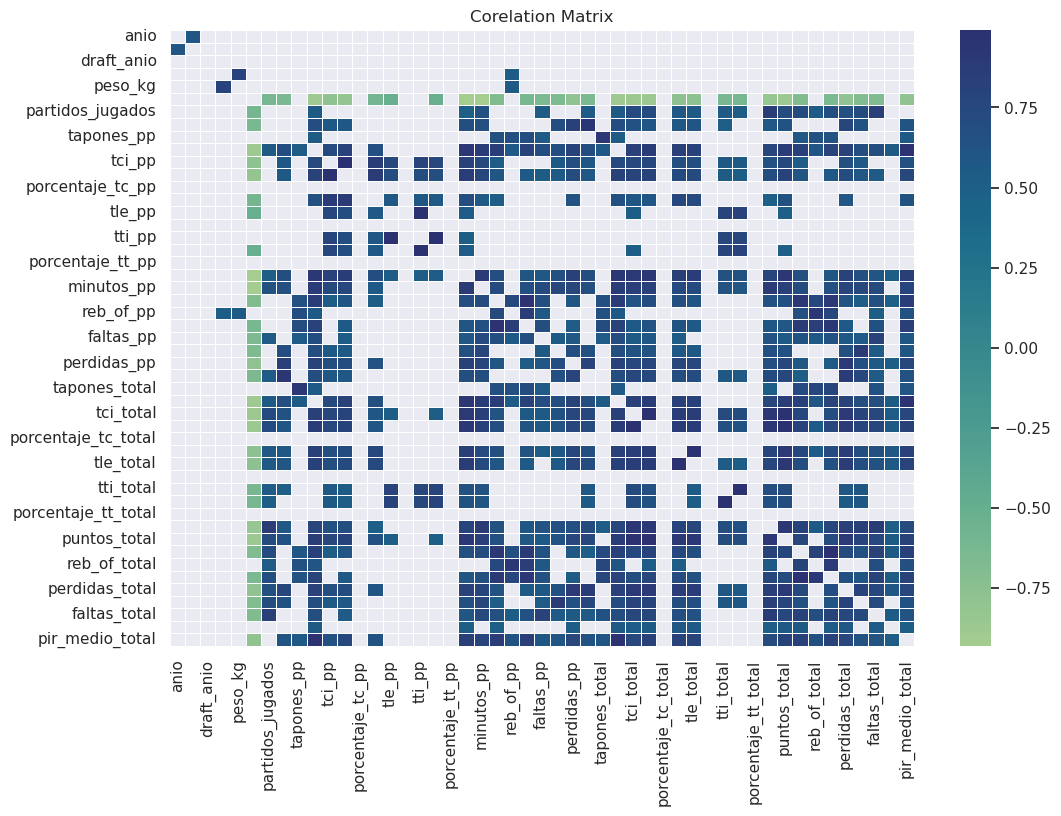

In [26]:
# Se visualiza la correlación entre las features siempre que sea mayor a 0.5

sns.set(rc={'figure.figsize':(12,8)})

corr = df_nba.corr()

sns.heatmap(corr[((corr >= 0.5) | (corr <= -0.5)) & (corr != 1)], 
            annot=False, 
            cmap = 'crest',
            linewidths=.5, 
            fmt= '.2f')

plt.title('Corelation Matrix');

__________________________________________________________________________________________________________________

## 3. Machine Learning

### 3.1. División en Train-Test

In [27]:
# Se divide el DataSet en train ('df_train') y test ('df_test')

df_train, df_test = train_test_split(df_nba, 
                                     test_size = 0.2,
                                     random_state = 0)

In [28]:
df_train.shape

(4194, 55)

In [29]:
df_test.shape

(1049, 55)

In [30]:
# Se aparta el conjunto de Test y se echa un vistazo al Train

data_report(df_train)

COL_N,temporada,anio,id_jugador,nombre_jugador,draft_anio,posicion,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total
DATA_TYPE,object,float64,int64,object,int64,object,float64,float64,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,11,11,1274,1272,29,7,23,121,540,31,31,2,84,104,33,641,3136,2607,438,2239,1565,497,2360,1565,340,295,369,109,52,144,44,26,52,507,168,641,1169,645,438,497,406,497,541,246,340,2151,1363,575,280,718,278,163,272,20,1606
CARDIN (%),0.26,0.26,30.38,30.33,0.69,0.17,0.55,2.89,12.88,0.74,0.74,0.05,2.0,2.48,0.79,15.28,74.77,62.16,10.44,53.39,37.32,11.85,56.27,37.32,8.11,7.03,8.8,2.6,1.24,3.43,1.05,0.62,1.24,12.09,4.01,15.28,27.87,15.38,10.44,11.85,9.68,11.85,12.9,5.87,8.11,51.29,32.5,13.71,6.68,17.12,6.63,3.89,6.49,0.48,38.29


__________________________________________________________________________________________________________________

### 3.2. Modelo de Regresión

Se quiere crear un modelo de Regresión para predecir el PIR medio de los jugadores en base a sus estadísticos.

### 3.2.1. División en Train-Test sobre conjunto Train

In [31]:
'''
Se pretende predecir el PIR de los jugadores. El PIR es una medida calculada a través de otras features de este
DataSet, por ello se eliminan las features utilizadas para conformarla y aquellas que correlacionen altamente
con las variables a través de las que se calcula el PIR medio.
Posteriormente se observa la correlación entre el PIR medio de los jugadores y el resto de las features.

'''

df_train_copy = df_train.copy()

In [32]:
df_train_copy.drop(columns = ['asistencias_total', 'tapones_total', 'tce_total', 'tle_total', 'tte_total',
                              'puntos_total', 'rebotes_total', 'robos_total', 'tci_total', 'tli_total', 
                              'tti_total', 'perdidas_total', 'faltas_total', 'faltas_tecnicas_total', 
                              'partidos_jugados', 'asistencias_pp', 'tapones_pp', 'eficiencia_tiro_pp', 'tci_pp',
                              'tce_pp', 'porcentaje_tc_pp', 'tli_pp', 'tle_pp', 'porcentaje_tl_pp', 'tti_pp', 
                              'tte_pp', 'porcentaje_tt_pp', 'puntos_pp', 'reb_def_pp', 'reb_of_pp', 
                              'total_rebotes_pp', 'faltas_pp', 'robos_pp', 'perdidas_pp', 'eficiencia_tiro_total',
                              'porcentaje_tc_total', 'porcentaje_tl_total', 'porcentaje_tt_total', 
                              'reb_def_total', 'reb_of_total'],
                   inplace = True)

In [33]:
# Se comprueba la correlación entre las variables del conjunto Train

corr_df = df_train_copy.corr()
corr_df.style.background_gradient(cmap = 'PuBu')

,anio,id_jugador,draft_anio,altura,peso_kg,num_ranking,minutos_pp,minutos_total,pir_medio_total
anio,1.000000,0.601948,0.071160,-0.088835,-0.095036,0.061620,-0.016054,-0.056720,0.037307
id_jugador,0.601948,1.000000,0.030083,-0.071485,-0.128996,0.222790,-0.198240,-0.224798,-0.156562
draft_anio,0.071160,0.030083,1.000000,0.011958,0.020613,-0.065309,0.061671,0.082683,0.060056
altura,-0.088835,-0.071485,0.011958,1.000000,0.806473,0.063780,-0.084162,-0.039991,0.163338
peso_kg,-0.095036,-0.128996,0.020613,0.806473,1.000000,0.007533,-0.030826,0.001687,0.226709
num_ranking,0.061620,0.222790,-0.065309,0.063780,0.007533,1.000000,-0.927247,-0.827183,-0.794635
minutos_pp,-0.016054,-0.198240,0.061671,-0.084162,-0.030826,-0.927247,1.000000,0.878096,0.775208
minutos_total,-0.056720,-0.224798,0.082683,-0.039991,0.001687,-0.827183,0.878096,1.000000,0.715412
pir_medio_total,0.037307,-0.156562,0.060056,0.163338,0.226709,-0.794635,0.775208,0.715412,1.000000


In [34]:
# Se analiza la correlación de las features con la variables target ('pir_medio_total')

pir_corr = abs(corr_df["pir_medio_total"])
pir_corr.sort_values(ascending = False)

pir_medio_total    1.000000
num_ranking        0.794635
minutos_pp         0.775208
minutos_total      0.715412
peso_kg            0.226709
altura             0.163338
id_jugador         0.156562
draft_anio         0.060056
anio               0.037307
Name: pir_medio_total, dtype: float64

In [35]:
# La correlación entre algunas features es muy alta entre ellas
# Se eliminan aquellas que tienen menos correlación con el target ('pir_medio_total') y las que tienen una correlación por debajo de 0.5 con el target

df_train_copy.drop(columns = ['minutos_total', 'altura', 'peso_kg', 'id_jugador', 'draft_anio', 'anio'],
                   inplace = True)

In [36]:
# Se comprueba de nuevo la correlación entre las features y el target

corr_df = df_train_copy.corr()
pir_corr = abs(corr_df["pir_medio_total"])
pir_corr.sort_values(ascending = False)

pir_medio_total    1.000000
num_ranking        0.794635
minutos_pp         0.775208
Name: pir_medio_total, dtype: float64

In [37]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4194 entries, 2145 to 2850
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temporada        4194 non-null   object 
 1   nombre_jugador   4194 non-null   object 
 2   posicion         4194 non-null   object 
 3   num_ranking      4194 non-null   int64  
 4   ciudad_equipo    4194 non-null   object 
 5   nombre_equipo    4194 non-null   object 
 6   conferencia      4194 non-null   object 
 7   minutos_pp       4194 non-null   float64
 8   pir_medio_total  4194 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 327.7+ KB


__________________________________________________________________________________________________________________

### 3.2.2. Modelo CatBoost

In [38]:
# Se divide de nuevo el conjunto Train

X_1 = df_train_copy.drop(columns = ["pir_medio_total"])


y_1 = df_train_copy["pir_medio_total"]

In [39]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,
                                                            y_1,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [40]:
# Se crea el modelo del CatBoost

model_catboost_1 = CatBoostRegressor(n_estimators = 200,
                                   loss_function = 'MAE',
                                   random_state = 42)

# Se crea el Pool, dónde se indican las variables categóricas

pool_train_1 = Pool(X_train_1, y_train_1,
                    cat_features=['temporada','nombre_jugador','posicion',
                                  'ciudad_equipo','nombre_equipo', 'conferencia'])

In [41]:
# Se entrena el modelo

model_catboost_1.fit(pool_train_1)

0:	learn: 4.0105683	total: 57.2ms	remaining: 11.4s
1:	learn: 3.9273083	total: 60.6ms	remaining: 6s
2:	learn: 3.8429421	total: 65.4ms	remaining: 4.29s
3:	learn: 3.7678728	total: 68.7ms	remaining: 3.37s
4:	learn: 3.6962520	total: 70.9ms	remaining: 2.76s
5:	learn: 3.6230278	total: 72.8ms	remaining: 2.35s
6:	learn: 3.5536264	total: 74.8ms	remaining: 2.06s
7:	learn: 3.4880350	total: 76.8ms	remaining: 1.84s
8:	learn: 3.4326381	total: 78.4ms	remaining: 1.66s
9:	learn: 3.3741690	total: 79.6ms	remaining: 1.51s
10:	learn: 3.3121522	total: 81.8ms	remaining: 1.41s
11:	learn: 3.2561396	total: 83.1ms	remaining: 1.3s
12:	learn: 3.2003743	total: 85.1ms	remaining: 1.22s
13:	learn: 3.1436698	total: 87.1ms	remaining: 1.16s
14:	learn: 3.0894440	total: 88.8ms	remaining: 1.09s
15:	learn: 3.0369445	total: 90.8ms	remaining: 1.04s
16:	learn: 2.9851951	total: 92.9ms	remaining: 1000ms
17:	learn: 2.9424897	total: 94.7ms	remaining: 958ms
18:	learn: 2.8922280	total: 96.8ms	remaining: 922ms
19:	learn: 2.8474184	tota

In [42]:
# Se comprueba el error MAE en Train

imp_feature_pred_train_1 = model_catboost_1.predict(X_train_1)

#print('MAE Error en el conjunto Train', mean_absolute_error(y_train_1, imp_feature_pred_train_1))
print("MAE", mean_absolute_error(y_train_1, imp_feature_pred_train_1))

MAE 1.484923552586611


In [43]:
# Se comprueba el error MAE en Test

imp_feature_pred_test_1 = model_catboost_1.predict(X_test_1)

#print('MAE Error en el conjunto Test', mean_absolute_error(y_test, imp_feature_pred_test_1))
print("MAE", mean_absolute_error(y_test_1, imp_feature_pred_test_1))

MAE 1.5028833251379021


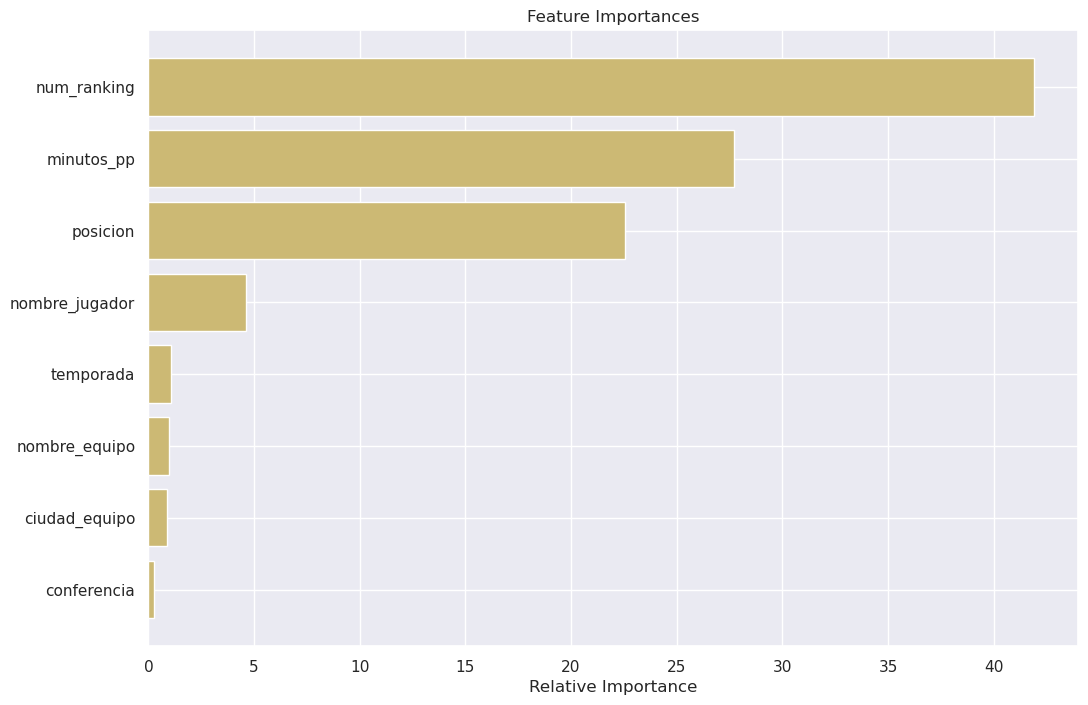

In [44]:
# Se visualiza la importancia de las variables (feature importance) en el modelo CatBoost utilizado

plot_feature_importance(X_1.columns, model_catboost_1.feature_importances_)

Se observa que la posición del jugador influye sobre el PIR medio total del mismo. Puede ser interesante transformar esta feature categórica a numérica de cara a mejorar el modelo.


Por otro lado, el resto de features categóricas no parecen ser realmente significativas sobre el target (*pir_medio_total*).

__________________________________________________________________________________________________________________

### 3.2.3. Modelo de Regresión Lineal

In [45]:
# Se hace una copia del conjunto Train

df_train_copy_2 = df_train_copy.copy()

In [46]:
# Se divide de nuevo el conjunto Train

X_2 = df_train_copy_2.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador','posicion',
                                  'ciudad_equipo','nombre_equipo', 'conferencia'])

y_2 = df_train_copy_2["pir_medio_total"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,
                                                            y_2,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [47]:
# Se crea el modelo

model_regression_2 = LinearRegression()

In [48]:
# Se entrena el modelo

model_regression_2.fit(X_train_2, y_train_2)

LinearRegression()

In [49]:
model_regression_2.intercept_

8.296215807938983

In [50]:
model_regression_2.coef_

array([-0.02085863,  0.16222702])

In [51]:
coef_df_2 = pd.DataFrame(model_regression_2.coef_, X_2.columns,
                         columns = ['Coefficient'])

coef_df_2

,Coefficient
num_ranking,-0.020859
minutos_pp,0.162227


In [52]:
# Se hacen las predicciones en el conjunto Test

pred_test_2 = model_regression_2.predict(X_test_2)
pred_test_2

array([ 1.08384284e+01,  2.19247588e-01,  3.95748689e+00,  9.78624944e+00,
        1.08199273e+01,  1.09473819e+01, -8.12078854e-01,  9.62401024e+00,
        7.62393933e+00,  4.67827316e+00,  9.62171968e+00,  7.75376357e+00,
        8.02026548e+00,  1.18558958e+01, -9.95170593e-01,  2.60940492e-01,
        7.97160955e+00,  4.77099780e+00,  1.00388923e+01,  6.61810745e+00,
        1.37192281e+01,  2.94702517e+00,  7.99475874e+00,  9.14891595e+00,
        9.43170144e+00,  6.41415099e+00,  1.43599895e+00,  3.82772354e+00,
        1.37678780e+01,  1.04954185e+01,  1.32093492e+01,  6.62042846e+00,
       -2.17481627e+00,  4.02472915e+00,  1.01779336e+01,  3.15097554e+00,
        2.59708875e+00,  6.28203010e+00,  1.97596578e+00,  2.83349670e+00,
        1.31351865e+01,  5.18207072e-01, -2.11224038e+00,  9.66578839e+00,
        1.39023138e+01,  2.59476774e+00, -8.00498168e-01, -3.27706622e-01,
        7.99012890e+00,  5.57059484e+00,  6.59259463e+00,  1.21316695e+01,
        1.22197461e+01,  

In [53]:
# Se calcula el error en el conjunsto Train

pred_train_2 = model_regression_2.predict(X_train_2)

print('MAE', metrics.mean_absolute_error(y_train_2, pred_train_2))
print('MSE', metrics.mean_squared_error(y_train_2, pred_train_2))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train_2, pred_train_2)))
print('R2', model_regression_2.score(X_train_2, y_train_2))

MAE 2.422199904067971
MSE 10.66105882724859
RMSE 3.2651276892716754
R2 0.6430241475505689


In [54]:
# Se calcula el error en el conjunsto Test

print('MAE', metrics.mean_absolute_error(y_test_2, pred_test_2))
print('MSE', metrics.mean_squared_error(y_test_2, pred_test_2))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_2, pred_test_2)))
print('R2', model_regression_2.score(X_test_2, y_test_2))

MAE 2.417974747307265
MSE 10.36838399070345
RMSE 3.219997514083427
R2 0.6373207235147111


Probando un **modelo de Regresión Lineal**, se ve que el MAE empeora con respecto al modelo anterior (*el modelo CatBoost*). Tampoco se obtiene un un R2 muy bueno.

__________________________________________________________________________________________________________________

### 3.2.4. Modelo GradientBoostingRegressor

In [55]:
# Se hace una copia del conjunto Train

df_train_copy_3 = df_train_copy.copy()

In [56]:
# Se divide de nuevo el conjunto Train

X_3 = df_train_copy_3.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador','posicion',
                                      'ciudad_equipo','nombre_equipo', 'conferencia'])

y_3 = df_train_copy_3["pir_medio_total"]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,
                                                            y_3,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [57]:
model_tree_3 = GradientBoostingRegressor()

model_tree_3.fit(X_train_3, y_train_3)

pred_test_3 = model_tree_3.predict(X_test_3)

In [58]:
# Se calcula el error en el conjunsto Train

pred_train_3 = model_tree_3.predict(X_train_3)

print('MAE', metrics.mean_absolute_error(y_train_3, pred_train_3))
print('MSE', metrics.mean_squared_error(y_train_3, pred_train_3))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train_3, pred_train_3)))
print('R2', model_tree_3.score(X_train_3, y_train_3))

MAE 2.0169426608756544
MSE 7.259915552303644
RMSE 2.694423046276075
R2 0.7569083348109317


In [59]:
# Se calcula el error en el conjunsto Test

print('MAE', metrics.mean_absolute_error(y_test_3, pred_test_3))
print('MSE', metrics.mean_squared_error(y_test_3, pred_test_3))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_3, pred_test_3)))
print('R2', model_tree_3.score(X_test_3, y_test_3))

MAE 2.1231557498709472
MSE 8.028530281927981
RMSE 2.8334661250715496
R2 0.7191672726916125


En un **modelo de GradientBoostingRegressor**, se ve que el MAE mejora con respecto al modelo CatBoost y el de Regresión Lineal. 


De hecho, sobre el conjunto Test el R2 es de 1.0. Es decir, que predice todos los valores a la perfección.

##### Se transforma la variable categórica 'posicion' a numérica y se prueba de nuevo de modelo definido anteriormente

In [60]:
# Se hace una copia del conjunto Train

df_train_copy_4 = df_train_copy.copy()

In [61]:
# Se transforma la variable 'posicion' de categórica a numérica haciendo un 'Ordinal Encoding'

posicion_dict = {'B': 0,
                 'PG': 1,
                 'A': 2, 
                 'AP': 3, 
                 'P': 4, 
                 'E-A': 5, 
                 'A-E': 6 
                }


df_train_copy_4['posicion'] = df_train_copy_4.posicion.replace(posicion_dict)
df_train_copy_4

,temporada,nombre_jugador,posicion,num_ranking,ciudad_equipo,nombre_equipo,conferencia,minutos_pp,pir_medio_total
2145,2015-2016,Jameer Nelson,0,202,Denver,Nuggets,Western,26.6,4.28
4065,2019-2020,Jordan Poole,0,211,Golden State,Warriors,Western,22.4,1.40
4231,2019-2020,Ante Zizic,4,377,Cleveland,Cavaliers,Eastern,10.0,4.86
2071,2015-2016,Evan Turner,5,128,Boston,Celtics,Eastern,28.0,11.12
4584,2020-2021,Raul Neto,0,220,Washington,Wizards,Eastern,21.9,6.66
...,...,...,...,...,...,...,...,...,...
5049,2021-2022,Garrison Mathews,0,182,Houston,Rockets,Western,26.3,3.15
3382,2018-2019,Mike Conley,0,26,Memphis,Grizzlies,Western,33.5,15.21
1771,2014-2015,Gigi Datome,2,323,Boston,Celtics,Eastern,10.0,2.86
2725,2016-2017,Tyler Zeller,4,368,Boston,Celtics,Eastern,10.3,3.78


In [62]:
# Se divide de nuevo el conjunto Train

X_4 = df_train_copy_4.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador',
                                      'ciudad_equipo','nombre_equipo', 'conferencia'])

y_4 = df_train_copy_4["pir_medio_total"]

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4,
                                                            y_4,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [63]:
# Se entrena el modelo

model_tree_4 = GradientBoostingRegressor()

model_tree_4.fit(X_train_4, y_train_4)

GradientBoostingRegressor()

In [64]:
# Se calcula el error en el conjunsto Train

pred_train_4 = model_tree_4.predict(X_train_4)

print('MAE', metrics.mean_absolute_error(y_train_4, pred_train_4))
print('MSE', metrics.mean_squared_error(y_train_4, pred_train_4))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train_4, pred_train_4)))
print('R2', model_tree_4.score(X_train_4, y_train_4))

MAE 1.5739100914792932
MSE 4.409008660044819
RMSE 2.0997639534111494
R2 0.8523683575543483


In [65]:
# Se calcula el error en el conjunsto Test

pred_test_4 = model_tree_4.predict(X_test_4)

print('MAE', metrics.mean_absolute_error(y_test_4, pred_test_4))
print('MSE', metrics.mean_squared_error(y_test_4, pred_test_4))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_4, pred_test_4)))
print('R2', model_tree_4.score(X_test_4, y_test_4))

MAE 1.631653488499783
MSE 4.908861447863582
RMSE 2.2155950550277868
R2 0.8282912438549739


Se prueba de nuevo un **modelo de GradientBoostingRegressor** tras haber transformado la variable *posicion* a numérica a través de un Ordinal Encoding.

Se observa que el rendimiento del modelo mejora en Train y que el conjunto Test se mantiene el R2 de 1.0.

### Se prueba en el conjunto Test

In [66]:
# Se aplican todos los cambios realizados en el conjunto Train sobre el Test

# Se transforma la variable 'posicion' de categórica a numérica haciendo un 'Ordinal Encoding'

df_test['posicion'] = df_test.posicion.replace(posicion_dict)


X_test_final = df_test.drop(columns = ['asistencias_total', 'tapones_total', 'tce_total', 'tle_total', 'tte_total',
                                       'puntos_total', 'rebotes_total', 'robos_total', 'tci_total', 'tli_total',
                                       'tti_total', 'perdidas_total', 'faltas_total', 'faltas_tecnicas_total',
                                       'tci_pp', 'tce_pp', 'porcentaje_tc_pp', 'tli_pp', 'tle_pp', 
                                       'porcentaje_tl_pp', 'total_rebotes_pp', 'faltas_pp','robos_pp', 
                                       'perdidas_pp', 'eficiencia_tiro_total', 'porcentaje_tc_total',
                                       'porcentaje_tl_total', 'porcentaje_tt_total', 'reb_def_total', 
                                       'reb_of_total', 'temporada','nombre_jugador', 'ciudad_equipo', 
                                       'nombre_equipo', 'conferencia', 'partidos_jugados', 'asistencias_pp', 
                                       'tapones_pp', 'eficiencia_tiro_pp', 'tti_pp', 'tte_pp', 'porcentaje_tt_pp',
                                       'puntos_pp', 'reb_def_pp', 'reb_of_pp', "pir_medio_total",
                                       'altura', 'peso_kg', 'anio', 'id_jugador', 'draft_anio', 'minutos_total'])


y_test_final = df_test["pir_medio_total"]

In [67]:
# Se calcula el error en el conjunsto Test

pred_test_final = model_tree_4.predict(X_test_final)

print('MAE', metrics.mean_absolute_error(y_test_final, pred_test_final))
print('MSE', metrics.mean_squared_error(y_test_final, pred_test_final))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_final, pred_test_final)))
print('R2', model_tree_4.score(X_test_final, y_test_final))

MAE 1.7178655498293784
MSE 5.10275040722096
RMSE 2.258926826442362
R2 0.816156533666696


## 3.4. Se guarda el modelo

In [68]:
with open('model_tree_finished.model', 'wb') as file:
    pickle.dump(model_tree_4, file) 

# El 'pickle' está en el Notebook -> 03-Logistic Regression (Digits)

## Para abrir el modelo

In [70]:
with open('model_tree_finished.model', 'rb') as file: # Usar 'rb' porque 'r' da un error
    logisticRegr = pickle.load(file)